In [45]:
%run /eos/project/l/liu/Toolbox/myToolbox.py

%config InlineBackend.figure_format = 'retina'

/eos/project/l/liu/Toolbox/myToolbox.py:24: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-957.21.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core
Your folder is /eos/home-a/ahuschau/www/acc-models-www/repository/ps/supplementary/transition_crossing/tof
Your IP is 172.17.0.8
2019-09-04 17:02:57


# Measurement data

In [2]:
filename = '/eos/project/l/liu/PS/data/2018/MD3187_TOF_transition_studies/2018.05.11_chromaticity_measurements/Horizontal_and_vertical_every_ms_final.csv'
Qxdp, Qx, Qydp, Qy = myToolbox.import_chromaticity(filename)

qx = myToolbox.fit_chromaticity(Qxdp, Qx, 2)
qy = myToolbox.fit_chromaticity(Qydp, Qy, 2)

In [4]:
qx.head()

,time,coefficients,tune,chromaticity,nl_chromaticity
0,300.0,"[-231.95140141941897, -3.100548806142805, 6.13...",6.131683,-3.100549,-231.951401
1,301.0,"[-51.08399379020165, -2.712013916154362, 6.133...",6.133576,-2.712014,-51.083994
2,302.0,"[-118.4202754628159, -2.280070034375593, 6.135...",6.135484,-2.280070,-118.420275
3,303.0,"[-383.60384615427273, -2.1066791813976327, 6.1...",6.137336,-2.106679,-383.603846
4,304.0,"[448.89848868579617, -4.192069036527379, 6.139...",6.139409,-4.192069,448.898489


# Simulation input

The chromaticity jump is currently not included in this simulation!

In [10]:
if 1:
    filename = '/eos/project/l/liu/PS/data/2018/MD3187_TOF_transition_studies/Gamma_t_evolution/Gamma_jump_optimization.mat'
    tr_elements = scipy.io.loadmat(filename, squeeze_me=True, struct_as_record=False)
    
    # Manual input required!
    # ----------------------------------------------------
    transition_time = 379

    # import different parameters required for simulations
    # ----------------------------------------------------
    momentum = {'time': [], 'value': []}
    momentum['value'] = tr_elements['TOF_after'].rmi_virtual_ps.PSBEAM.MOMENTUM.value.Y
    momentum['time'] = tr_elements['TOF_after'].rmi_virtual_ps.PSBEAM.MOMENTUM.value.X

    gamma = {'time': [], 'value': []}
    gamma['value'] = (myToolbox.P_GeVToEk_GeV(momentum['value']) + myToolbox.E0_GeV())/myToolbox.E0_GeV()
    gamma['time'] = tr_elements['TOF_after'].rmi_virtual_ps.PSBEAM.MOMENTUM.value.X

    tuneH = {'time': [], 'value': []}
    tuneH['time'] = qx['time']
    tuneH['value'] = qx['tune']

    tuneV = {'time': [], 'value': []}
    tuneV['time'] = qy['time']
    tuneV['value'] = qy['tune']

    factor_DB_A = tr_elements['TOF_after'].PR_GSQTRJ_DB_A.Gain.gain.value
    factor_DB_B = tr_elements['TOF_after'].PR_GSQTRJ_DB_B.Gain.gain.value

    doublet_A = {'time': [], 'value': []}
    doublet_B = {'time': [], 'value': []}
    doublet_A['time'] = tr_elements['TOF_after'].PR_GSQTRJ_DB_V.Setting.value.amplitudes.X + transition_time - 100
    doublet_B['time'] = tr_elements['TOF_after'].PR_GSQTRJ_DB_V.Setting.value.amplitudes.X + transition_time - 100
    doublet_A['value'] = tr_elements['TOF_after'].PR_GSQTRJ_DB_V.Setting.value.amplitudes.Y * factor_DB_A
    doublet_B['value'] = tr_elements['TOF_after'].PR_GSQTRJ_DB_V.Setting.value.amplitudes.Y * factor_DB_B

    factor_TR_A = tr_elements['TOF_after'].PR_GSQTRJ_TR_A.Gain.gain.value
    factor_TR_B = tr_elements['TOF_after'].PR_GSQTRJ_TR_B.Gain.gain.value

    triplet_A = {'time': [], 'value': []}
    triplet_B = {'time': [], 'value': []}
    triplet_A['time'] = tr_elements['TOF_after'].PR_GSQTRJ_TR_V.Setting.value.amplitudes.X + transition_time - 100
    triplet_B['time'] = tr_elements['TOF_after'].PR_GSQTRJ_TR_V.Setting.value.amplitudes.X + transition_time - 100
    triplet_A['value'] = tr_elements['TOF_after'].PR_GSQTRJ_TR_V.Setting.value.amplitudes.Y * factor_TR_A
    triplet_B['value'] = tr_elements['TOF_after'].PR_GSQTRJ_TR_V.Setting.value.amplitudes.Y * factor_TR_B

    # combine the complete data set during the time of interest in a data frame
    # ----------------------------------------------------
    transition = pnd.DataFrame()

    transition['time'] = np.arange(200, 451, 1)
    transition['gamma'] = np.interp(transition['time'], gamma['time'], gamma['value'])
    transition['momentum'] = np.interp(transition['time'], momentum['time'], momentum['value'])
  
    transition['doublet_A'] = np.interp(transition['time'], doublet_A['time'], doublet_A['value'])
    transition['doublet_B'] = np.interp(transition['time'], doublet_B['time'], doublet_B['value'])

    transition['triplet_A'] = np.interp(transition['time'], triplet_A['time'], triplet_A['value'])
    transition['triplet_B'] = np.interp(transition['time'], triplet_B['time'], triplet_B['value'])

    transition['Qh'] = np.interp(transition['time'], tuneH['time'], tuneH['value'])
    transition['Qv'] = np.interp(transition['time'], tuneV['time'], tuneV['value'])   
    
    transition.to_pickle('transition_table_tof.pkl')
else:
    transition = pnd.read_pickle('transition_table_tof.pkl')

In [19]:
transition.head()

,time,gamma,momentum,doublet_A,doublet_B,triplet_A,triplet_B,Qh,Qv
0,200,2.705781,2.359014,0.0,0.0,0.0,0.0,6.131683,6.301385
1,201,2.722955,2.376346,0.0,0.0,0.0,0.0,6.131683,6.301385
2,202,2.740771,2.394309,0.0,0.0,0.0,0.0,6.131683,6.301385
3,203,2.759230,2.412902,0.0,0.0,0.0,0.0,6.131683,6.301385
4,204,2.778335,2.432125,0.0,0.0,0.0,0.0,6.131683,6.301385


# Run MAD-X

In [21]:
from cpymad.madx import Madx, Sequence
from IPython.display import clear_output

In [23]:
if 1:
    madx = Madx()
    madx.command.beam('PARTICLE=PROTON, PC := 2.35;')
    madx.input('BRHO := BEAM->PC * 3.3356;')
    # call sequence of main units
    madx.call('/eos/home-a/ahuschau/www/acc-models-www/repository/ps/ps_mu.seq')
    # call sequence of straight section elements
    madx.call('/eos/home-a/ahuschau/www/acc-models-www/repository/ps/ps_ss.seq')
    # call general strength file
    madx.call('/eos/home-a/ahuschau/www/acc-models-www/repository/ps/ps.str')
    madx.call('/eos/home-a/ahuschau/www/acc-models-www/repository/ps/scenarios/tof/1_flat_bottom/ps_fb_tof.str')

    result = pnd.DataFrame(columns = ['time', 'momentum', 'gamma', 'gammatr', 'Qh', 'Qv', 'betx', 'bety', 'disp'])

    for index, row in transition.iterrows():
        print('Cycle time = ' + str(row['time']))
        print('')

        madx.command.beam('PARTICLE=PROTON, PC := ' + str(row['momentum']))

        madx.input('ITRIPA = ' + str(row['triplet_A']))
        madx.input('ITRIPB = ' + str(row['triplet_B']))

        madx.input('IDOUBA = ' + str(row['doublet_A']))
        madx.input('IDOUBB = ' + str(row['doublet_B']))

        madx.command.use(sequence = 'PS')
        madx.command.match()
        madx.input('GLOBAL, Q1 = ' + str(row['Qh']) + ', Q2 = ' + str(row['Qv']))
        madx.input('VARY, NAME = k1_f, STEP=1e-5')
        madx.input('VARY, NAME = k1_d, STEP=1e-5')
        madx.input('LMDIF, CALLS=10000, TOLERANCE = 10E-18')
        madx.input('endmatch')

        madx.command.use(sequence = 'PS')
        madx.command.twiss('table=transition,sequence=PS')
        table = madx.table.transition
        summ = madx.table.summ

        gamma = madx.eval('beam->gamma')
        gammatr = summ['gammatr'][0]
        beta = np.sqrt(1 - 1/madx.eval('beam->gamma')**2)
        pc = madx.eval('beam->pc')
        Qh = summ['q1'][0]
        Qv = summ['q2'][0]

        result.loc[index] = [row['time'], pc, gamma, gammatr, Qh, Qv, table['betx'], table['bety'], table['dx']*beta]

        clear_output()

    result.to_pickle('gammatr_evolution_tof.pkl')
else:
    result = pnd.read_pickle('gammatr_evolution_tof.pkl')

In [46]:
result.head()

,time,momentum,gamma,gammatr,Qh,Qv,betx,bety,disp
0,200.0,2.359014,2.705782,6.007127,6.131683,6.301385,"[20.73946422849306, 20.73946422849306, 20.7394...","[12.112917239828295, 12.112917239828295, 12.11...","[3.1563376201596274, 3.1563376201596274, 3.156..."
1,201.0,2.376346,2.722955,6.007127,6.131683,6.301385,"[20.73946422849306, 20.73946422849306, 20.7394...","[12.112917239828295, 12.112917239828295, 12.11...","[3.1563376201596527, 3.1563376201596527, 3.156..."
2,202.0,2.394309,2.740771,6.007127,6.131683,6.301385,"[20.73946422849306, 20.73946422849306, 20.7394...","[12.112917239828295, 12.112917239828295, 12.11...","[3.1563376201596376, 3.1563376201596376, 3.156..."
3,203.0,2.412902,2.759231,6.007127,6.131683,6.301385,"[20.73946422849306, 20.73946422849306, 20.7394...","[12.112917239828295, 12.112917239828295, 12.11...","[3.156337620159637, 3.156337620159637, 3.15633..."
4,204.0,2.432125,2.778336,6.007127,6.131683,6.301385,"[20.73946422849306, 20.73946422849306, 20.7394...","[12.112917239828295, 12.112917239828295, 12.11...","[3.156337620159645, 3.156337620159645, 3.15633..."


# Plots

Text(0,0.5,'Gamma')

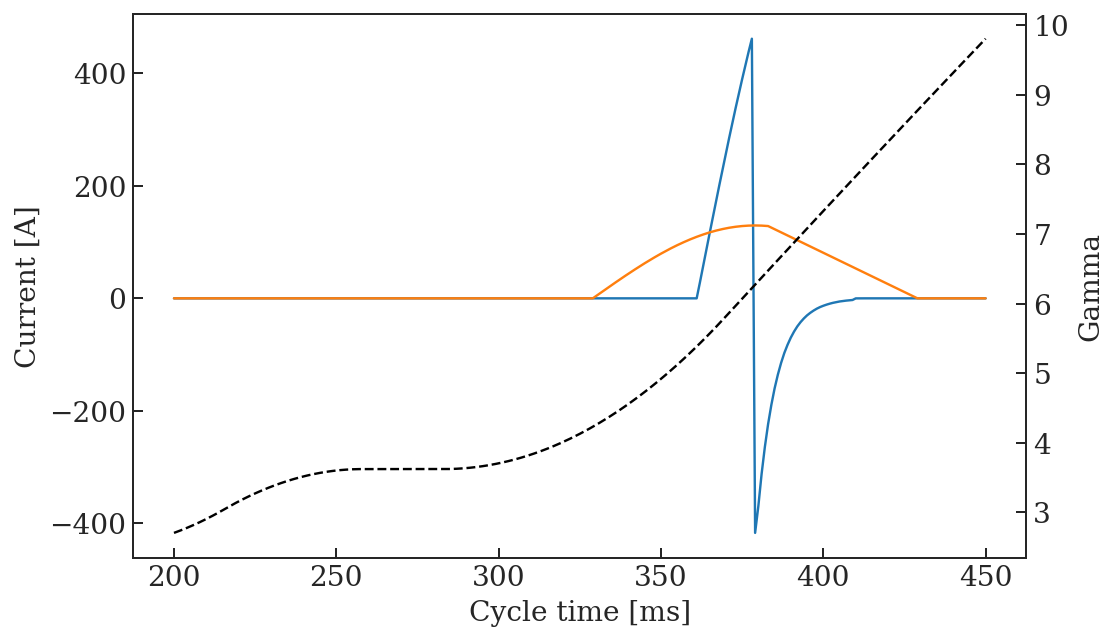

In [28]:
%matplotlib inline
f,ax = plt.subplots(1,figsize=(8,5))

ax.plot(transition['time'], transition['doublet_A'])
ax.plot(transition['time'], transition['triplet_A'])
ax.set_xlabel('Cycle time [ms]')
ax.set_ylabel('Current [A]')

ax2 = ax.twinx()
ax2.plot(transition['time'], transition['gamma'], '--k')
ax2.set_ylabel('Gamma')

# plt.xlim(1850,2050)

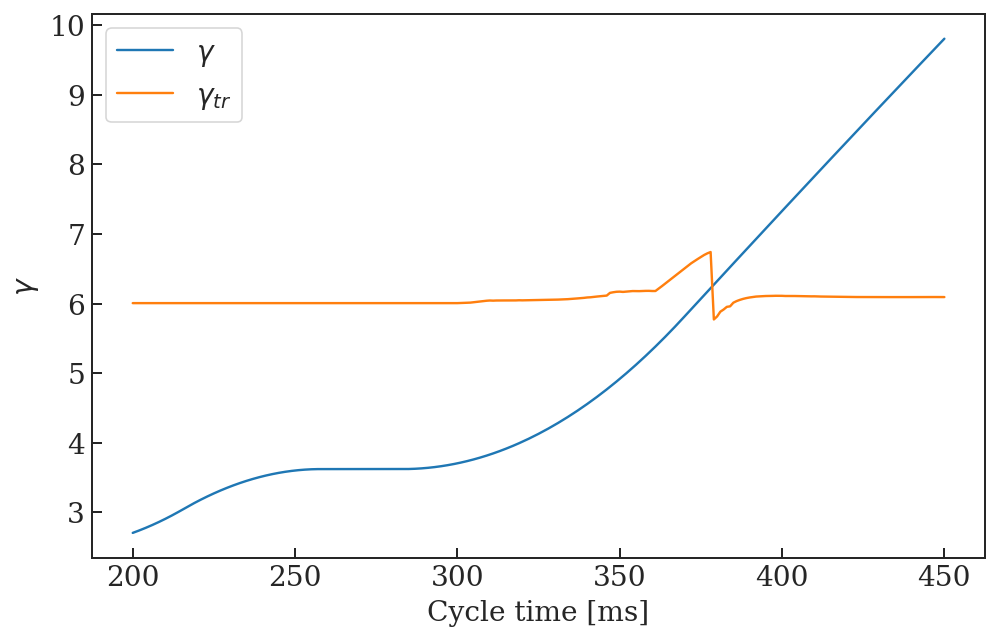

In [31]:
%matplotlib inline
f,ax = plt.subplots(1,figsize=(8,5))

ax.plot(result['time'], result['gamma'], label = '$\gamma$')
ax.plot(result['time'], result['gammatr'], label = '$\gamma_{tr}$')
ax.set_xlabel('Cycle time [ms]')
ax.set_ylabel('$\gamma$')
ax.legend(loc = 'upper left')
# ax.set_xlim(925, 1025)
# ax.set_ylim(5, 7)

# Bokeh plot for website

In [32]:
from bokeh.plotting import figure, output_file, output_notebook, show, save, ColumnDataSource
from bokeh.models import Legend, LinearAxis, Range1d, CustomJS, Slider, Span, Panel, Tabs
from bokeh.layouts import row, column, gridplot

In [33]:
def gamma_jump_bokeh(transition, filename, output):
    
    # definition of parameters to be shown when hovering the mouse over the data points
    tooltips = [("parameter", "$name"), ("value [m]", "$y")]
    
    if output == 'file':
        # output to static HTML file
        output_file(filename, mode="inline")
    elif output == 'inline':
        output_notebook()
    
    source = ColumnDataSource(transition)
        
    x = Range1d(np.min(source.data['time']), np.max(source.data['time']), bounds="auto")
    y = Range1d(5., 7., bounds="auto")
    p = Range1d(np.min(source.data['momentum']), np.max(source.data['momentum']), bounds="auto")

    # create a new plot with a title and axis labels
    f = figure(title="", x_axis_label='Cycle time [ms]', y_axis_label='Gamma', width=1000, height=500, x_range=x, y_range=y, tools="box_zoom, pan, reset, hover", active_drag = 'box_zoom', tooltips = tooltips)

    f.axis.major_label_text_font = 'times'
    f.axis.axis_label_text_font = 'times'
    f.axis.axis_label_text_font_style = 'normal'
    f.outline_line_color = 'black'
    f.sizing_mode = 'scale_width'

    cols = ['darkblue', 'salmon']

    f.line('time', 'gamma', source=source, name = u"\u03B3", line_width=1.5, line_color = cols[0])
    f.line('time', 'gammatr', source=source, name = u"\u03B3tr", line_width=1.5, line_color = cols[1])

    # Setting the second y axis range name and range
    f.extra_y_ranges = {"p": p}

    # Adding the second y axis to the plot.  
    f.add_layout(LinearAxis(y_range_name="p", axis_label='Momentum [GeV/c]', axis_label_text_font = 'times', axis_label_text_font_style = 'normal', major_label_text_font = 'times'), 'right')
    f.line('time', 'momentum', source=source, name = 'momentum', line_width=1.5, line_color = 'black', y_range_name="p", line_dash = 'dashed')

    legend = Legend(items=[(u"\u03B3", [f.renderers[0]]), (u"\u03B3tr", [f.renderers[1]]), ("p", [f.renderers[2]])], location='top_left')
    f.add_layout(legend)
    legend.label_text_font = 'times'
    legend.click_policy="hide"

    if output == 'file':
        save(f)
    elif output == 'inline':
        show(f)

In [52]:
def magnetic_cycle_bokeh(mat_file, transition_time, filename, output):
    
    # definition of parameters to be shown when hovering the mouse over the data points
    tooltips = [("parameter", "$name"), ("element", "@name"), ("value [m]", "$y")]
    
    if output == 'file':
        # output to static HTML file
        output_file(filename, mode="inline")
    elif output == 'inline':
        output_notebook()
    
    # define the datasource
    mat_data = myToolbox.japcMatlabImport(mat_file)
    data = pnd.DataFrame(columns = ['t', 'B', 'p'])

    data['t'] = np.arange(mat_data.PR_BMEAS_B_SD.Samples.value.firstSampleTime, len(mat_data.PR_BMEAS_B_SD.Samples.value.samples)*mat_data.PR_BMEAS_B_SD.Samples.value.samplingTrain, mat_data.PR_BMEAS_B_SD.Samples.value.samplingTrain)
    data['B'] = mat_data.PR_BMEAS_B_SD.Samples.value.samples/1e4
    if 'ion' in filename: 
        data['p'] = data['B'] * 70.07 /3.3356 *54./208
    else:
        data['p'] = data['B'] * 70.07 /3.3356

    source = ColumnDataSource(data)

    # calculate plot limits based on data range
    ymax = np.floor(np.max(data['B'])*10+1)/10

    # create a new plot with a title and axis labels
    f = figure(title="", x_axis_label='Cycle time [ms]', y_axis_label='Magnetic field [T]', width=400, height=250, x_range=Range1d(0, data['t'].iloc[-1], bounds="auto"), y_range=Range1d(0, ymax), tools="box_zoom, pan, reset", active_drag = 'box_zoom')

    f.axis.major_label_text_font = 'times'
    f.axis.axis_label_text_font = 'times'
    f.axis.axis_label_text_font_style = 'normal'
    f.outline_line_color = 'black'
    f.sizing_mode = 'scale_width'

    f.line('t', 'B', source=source, line_width=1.5, line_color = 'firebrick')
    vline = Span(location = transition_time, dimension = 'height', line_color = 'black', line_dash = 'dashed', line_width = 1)
    f.renderers.extend([vline])

    # Setting the second y axis range name and range
    if 'ion' in filename: 
        f.extra_y_ranges = {"p": Range1d(0, ymax * 70.07 / 3.3356*54./208)}
    else:
        f.extra_y_ranges = {"p": Range1d(0, ymax * 70.07 / 3.3356)}

    # Adding the second y axis to the plot.  
    f.add_layout(LinearAxis(y_range_name="p", axis_label='Momentum [GeV/c]', axis_label_text_font = 'times', axis_label_text_font_style = 'normal', major_label_text_font = 'times'), 'right')
    dx = f.line('t', 'p', source=source, line_width=1.5, line_color = 'darkblue', y_range_name="p")
    
    if output == 'file':
        save(f)
    elif output == 'inline':
        show(f)

In [54]:
mat_file = '/eos/user/a/ahuschau/www/chromaticity_measurements/measurement_data/TOF/2018.10.29.11.17.42.760.mat'
magnetic_cycle_bokeh(mat_file, transition_time, 'magnetic_cycle.html', 'file')

In [55]:
gamma_jump_bokeh(result[['time', 'momentum', 'gamma', 'gammatr', 'Qh', 'Qv']], 'gamma_jump.html', 'file')